# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID', 'RegionName', 'City', 
                                  'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='time')
    
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [2]:
def create_df(column, data):
    df = pd.DataFrame(data[data.RegionName == column])
    return df

In [3]:
def plot_roi(df, title=None, ylabel=None, legend=False):
    df.plot(legend=legend)
    plt.title(title)
    plt.xticks(rotation=70)
    plt.ylabel(ylabel)

In [4]:
def dickey_fuller(array):
    test = adfuller(array)
    output = pd.Series(test[0:4], index = ['Test Stat','p-value','# Lags used', '# of obs'])
    return output

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error as mse
from math import sqrt

plt.style.use('ggplot')

In [6]:
df = pd.read_csv('zillow_data.csv')
# df.head()

# Step 2: Data Preprocessing

In [7]:
# create a new dataframe with the difference between the values in recent years after the housing crisis
series09 = df['2009-04']
series18 = df['2018-04']
zipcode = df['RegionName']

# add the difference and noramalize it
diff_df = pd.concat([zipcode, series09, series18], axis=1)
diff_df['diff'] = (diff_df['2018-04'] - diff_df['2009-04'])/diff_df['2009-04']*100

# diff_df.hist('diff',bins=20, density=True)

In [8]:
# create a cutoff for the top 98th percentile in ROI increase
diff_cutoff = diff_df['diff'].quantile(0.98)
diff_cutoff

89.18667081689597

In [9]:
#   find the zip codes that remained the most stable during the housing crisis December 2007 – June 2009.
series07 = df['2007-12']
series18 = df['2009-06']
zipcode = df['RegionName']

# add the difference and noramalize it
stability_df = pd.concat([zipcode, series07, series18], axis=1)
stability_df['diff'] = (stability_df['2009-06'] - stability_df['2007-12'])/stability_df['2007-12']*100

# stability_df.hist('diff',bins=20, density=True)

In [10]:
# create a cutoff for the top 98th percentile for most stable zip codes
stability_cutoff = stability_df['diff'].quantile(0.98)

In [11]:
# # Scale the values
# scaler = MinMaxScaler()
# melt_df[['value']] = scaler.fit_transform(melt_df[['value']])

In [12]:
# grab the zip codes that show the most ROI
diff_zipcodes = diff_df[diff_df['diff'] > diff_cutoff]['RegionName']
diff_zipcodes.head()

27    94565
29    20002
70    11221
75    90034
76    94110
Name: RegionName, dtype: int64

In [13]:
# grab the most stable zip codes in terms of ROI during the housing crisis 
stable_zipcodes = stability_df[stability_df['diff'] > stability_cutoff]['RegionName']
stable_zipcodes.head()

20     10011
21     10128
43     73099
272    10021
325    42101
Name: RegionName, dtype: int64

In [14]:
melt_df = melt_data(df)
melt_df.set_index('time', inplace=True)
melt_df.drop(['RegionID', 'SizeRank'], inplace=True, axis=1)
# melt_df.head()

In [23]:
# remove all observations before housing crisis
melt_df = melt_df[melt_df.index >= '2009-06-01']
melt_df.head()

,RegionName,City,State,Metro,CountyName,value
time,,,,,,
2009-06-01,60657,Chicago,IL,Chicago,Cook,786900.0
2009-06-01,75070,McKinney,TX,Dallas-Fort Worth,Collin,199700.0
2009-06-01,77494,Katy,TX,Houston,Harris,246800.0
2009-06-01,60614,Chicago,IL,Chicago,Cook,1010200.0
2009-06-01,79936,El Paso,TX,El Paso,El Paso,119100.0


In [121]:
# out of the most stable zip codes pick those with the highest ROI
stable_return = melt_df.loc[melt_df['RegionName'].isin(list(stable_zipcodes))]
high_return = melt_df.loc[melt_df['RegionName'].isin(list(diff_zipcodes))]
high_return

,RegionName,City,State,Metro,CountyName,value
time,,,,,,
2009-06-01,94565,Pittsburg,CA,San Francisco,Contra Costa,184500.0
2009-06-01,20002,Washington,DC,Washington,District of Columbia,359100.0
2009-06-01,11221,New York,NY,New York,Kings,439300.0
2009-06-01,90034,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,695600.0
2009-06-01,94110,San Francisco,CA,San Francisco,San Francisco,710300.0
2009-06-01,33139,Miami Beach,FL,Miami-Fort Lauderdale,Miami-Dade,1408800.0
2009-06-01,90026,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,471500.0
2009-06-01,11211,New York,NY,New York,Kings,617800.0
2009-06-01,94533,Fairfield,CA,Vallejo,Solano,187600.0


In [25]:
# split the data for testing and training purposes
train_df = high_return[high_return.index < '2016-04-01']
test_df = high_return[high_return.index >= '2016-04-01']

# Step 4: EDA and Visualization
Perform basic EDA as you would building any model, then create at least 3 visualizations.  At least one of the visualizations should have time on the x-axis.  Axes should be labeled and any text should be legible.

In [119]:
plt.rcParams['figure.figsize'] = 8, 5

# create a different dataframe for every zip code
zip_codes = train_df.RegionName.unique()

# create a list of dataframes
model_df_list = []
for zip_code in zip_codes:
    model_df_list.append(create_df(zip_code, train_df))
    
# check the possible cannidates for stationarity    
dicky_results = []
for dframe in model_df_list:
    dicky_results.append(dickey_fuller(dframe.value))

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

len(model_df_list)

283

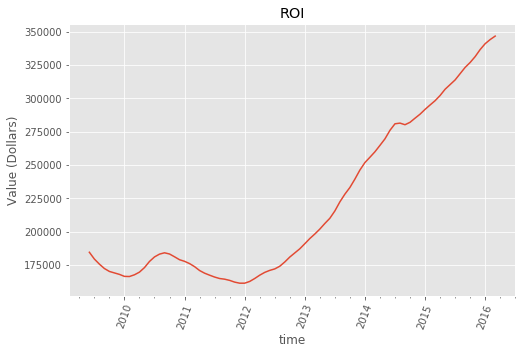

In [27]:
# extract the cheapest zip code to model
model1_df = model_df_list[0][['value']]
plot_roi(model1_df, title='ROI', ylabel='Value (Dollars)', legend=False)

Test Stat      -0.938031
p-value         0.775190
# Lags used    12.000000
# of obs       68.000000
dtype: float64

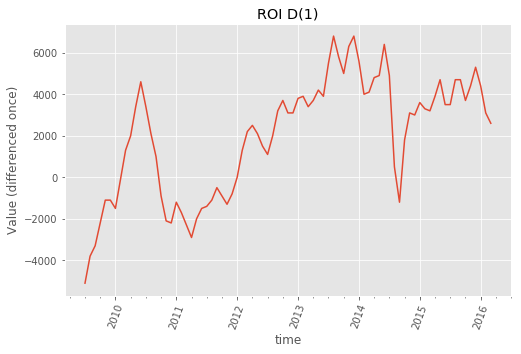

In [29]:
# difference once to eliminate tred
model1_df_once = model1_df.diff()
model1_df_once.dropna(inplace=True)

# plot the differenced data
plot_roi(model1_df_once, title='ROI D(1)', ylabel='Value (differenced once)', legend=False)

# check for stationarity
dickey_fuller(model1_df_once.value)

Test Stat      -3.947546
p-value         0.001712
# Lags used    11.000000
# of obs       68.000000
dtype: float64

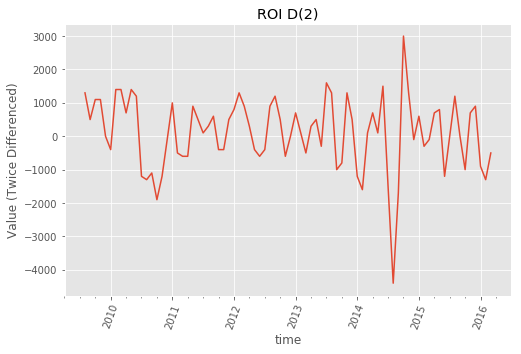

In [30]:
# difference twice and check if the significanse increased
model1_df_twice = model1_df_once.diff()
model1_df_twice.dropna(inplace=True)

# plot the differenced data
plot_roi(model1_df_twice, title="ROI D(2)", ylabel='Value (Twice Differenced)', legend=False)

# check for stationarity
dickey_fuller(model1_df_twice.value)

In [ ]:
# check acf and pacf to determin order of MA and AR respectively
# Run the first model - stationarity met after differencing for the 2nd time

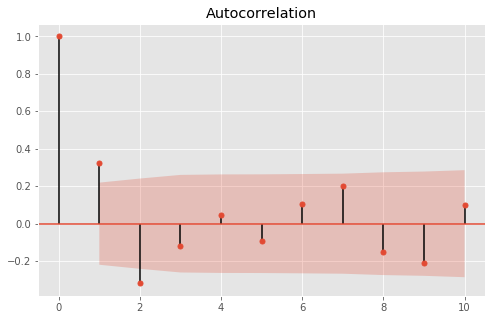

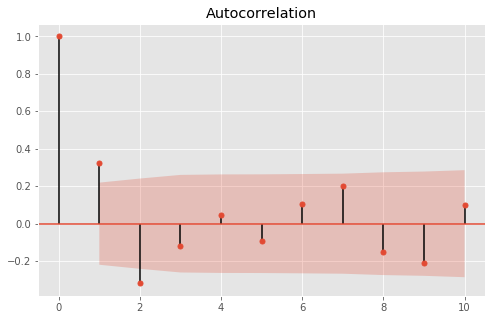

In [73]:
# check auto correlation and determine the order of MA
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(model1_df_twice, alpha=.05, lags=10)

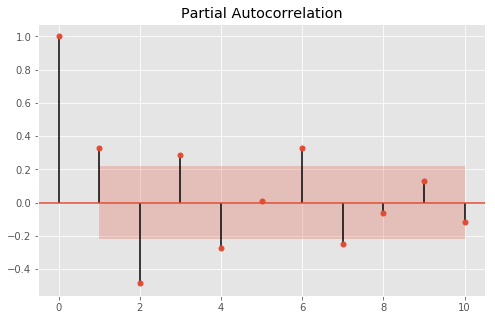

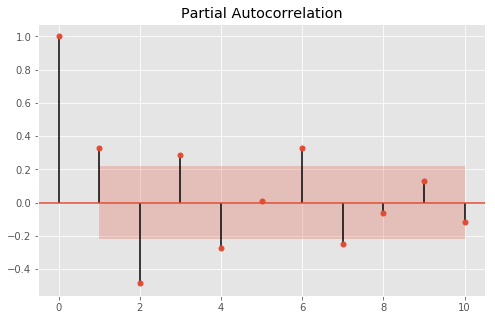

In [74]:
# check partial correlation and determine the order of AR
plot_pacf(model1_df_twice, alpha=.05, lags=10)

In [112]:
# running model on the cheapest zip code in the list of best possible zipcodes
#ARIMA model for high ROI - seems like AR(4) I(2) MA(2) . 
# However, AR(0) I(1) MA(1), produces the lowest std error with only slightly higher RMSE
high_model1 = ARIMA(model1_df, order=(1,2,1))
high_model_fit1 = high_model1.fit(disp=0)
print(high_model_fit1.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   78
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -669.466
Method:                       css-mle   S.D. of innovations           1256.175
Date:                Fri, 06 Sep 2019   AIC                           1346.932
Time:                        13:21:31   BIC                           1356.359
Sample:                    10-01-2009   HQIC                          1350.706
                         - 03-01-2016                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.5765      6.142      0.094      0.925     -11.461      12.614
ar.L1.D2.value    -0.0099      0.114     -0.087      0.931      -0.233       0.213
ma.L1.D2.value    -1.0000      0.032

D:\Programs\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Programs\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


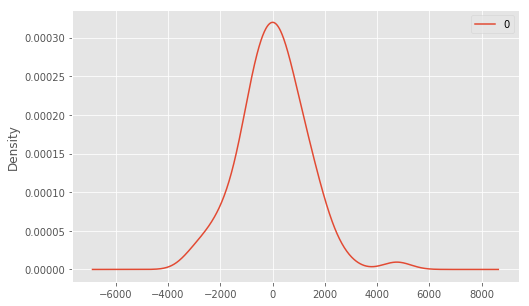

In [113]:
# check residual distribution
residuals = pd.DataFrame(high_model_fit1.resid)
residuals.plot(kind='kde')

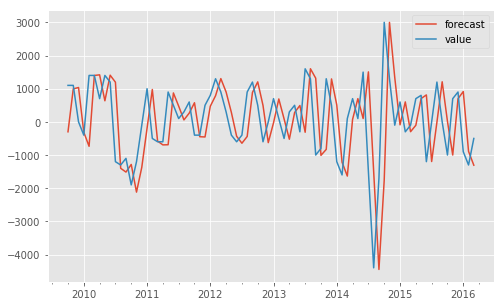

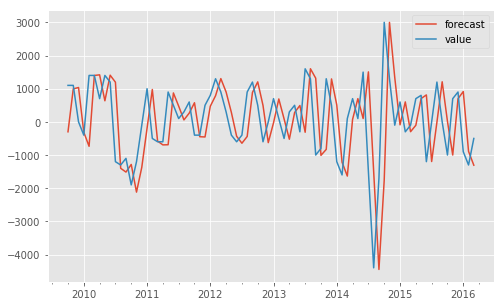

In [114]:
# compare at our forecast in comparison to the actual values for the first zip code
high_model_fit1.plot_predict()

In [115]:
# check the root mean squared error
region_name1 = int(model_df_list[0].RegionName.unique())
y_hat = high_model_fit1.forecast(108)[0]
y_hat = y_hat[86:]

# data and check for the root mean squared error
y_obs_test = test_df[test_df.RegionName == region_name1]


# get the last 22 observations
y_obs = y_obs_test['value']
y_obs = y_obs[3:]
RMSE = sqrt(mse(y_obs, y_hat)) # 1 1 0 lowest rmse

RMSE

389170.77479813545

In [116]:
# predict the ROI at 2019-04-01 for model one (58318)
predict2019 = high_model_fit1.forecast(120)[0]

# 2019-04-01 predict value
yp_2019 = int(predict2019[-1])

# 2018-04-01 actual value
yobs_2018 = int(y_obs_test[y_obs_test.index == '2018-04-01']['value'])

# estimate the ROI 58318
model1_roi = (yp_2019 - yobs_2018)/yobs_2018*100
print(f"{round(model1_roi,2)}% return")

-99.44% return


# Run a second model to predict the ROI for the second cheapest zip code

In [32]:
# extract the second zip code for later use
region_name2 = int(model_df_list[1].RegionName.unique())

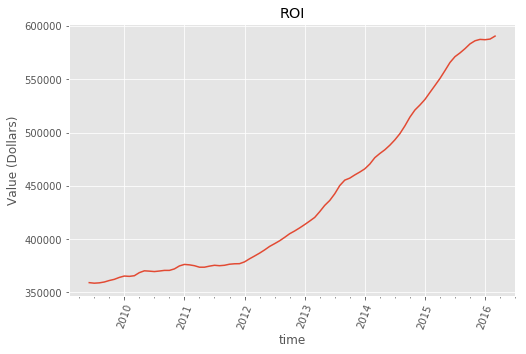

In [33]:
# check for trends and stationarity for the second model
model2_df = model_df_list[1][['value']]
plot_roi(model2_df, title='ROI', ylabel='Value (Dollars)', legend=False)

Test Stat      -0.938031
p-value         0.775190
# Lags used    12.000000
# of obs       68.000000
dtype: float64

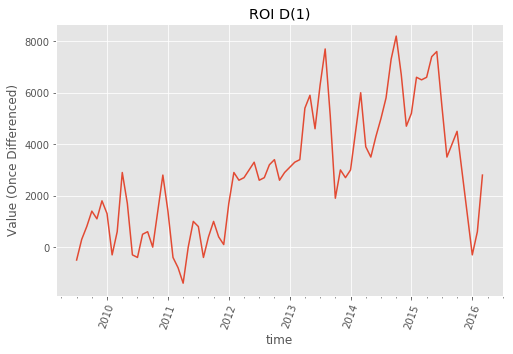

In [34]:
# difference once to eliminate tred
model2_df_once = model2_df.diff()
model2_df_once.dropna(inplace=True)

# plot the differenced data
plot_roi(model2_df_once, title='ROI D(1)', ylabel='Value (Once Differenced)', legend=False)

# check for stationarity
dickey_fuller(model1_df_once.value)

Test Stat      -3.874662
p-value         0.002229
# Lags used     5.000000
# of obs       74.000000
dtype: float64

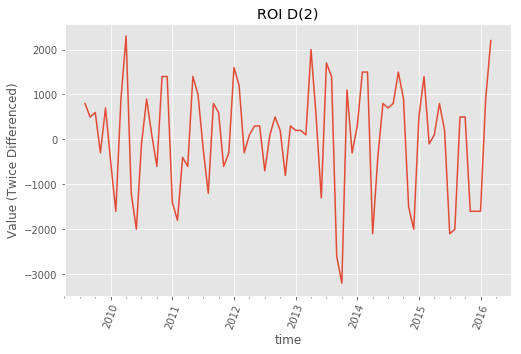

In [35]:
# difference twice to eliminate tred
model2_df_twice = model2_df_once.diff()
model2_df_twice.dropna(inplace=True)

# plot the differenced data
plot_roi(model2_df_twice, title='ROI D(2)', ylabel='Value (Twice Differenced)', legend=False)

# check for stationarity
dickey_fuller(model2_df_twice.value)

In [ ]:
# check acf and pacf to determin order of MA and AR respectively when the data is stationary
# Run the second model - stationarity met after differencing for the 1st time

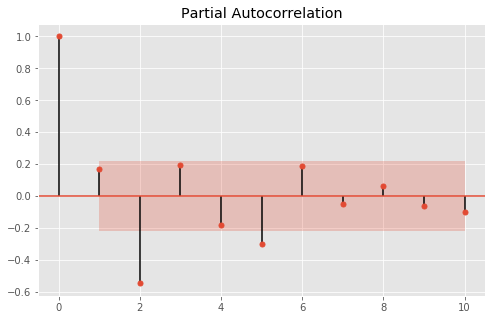

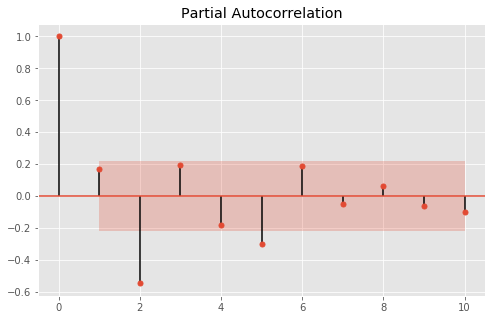

In [36]:
# check partial correlation and determine the order of AR
plot_pacf(model2_df_twice, alpha=.05, lags=10)

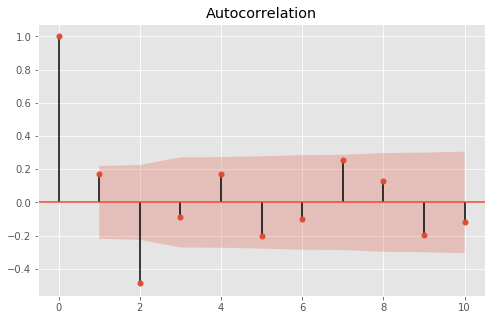

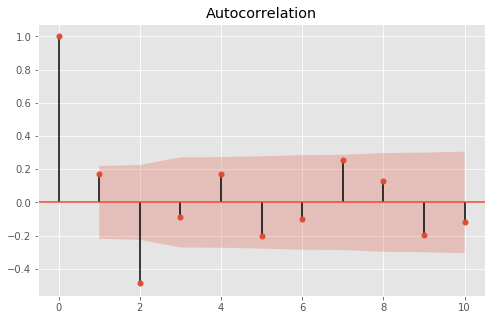

In [37]:
# check auto correlation and determine the order of MA
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(model2_df_twice, alpha=.05, lags=10)

# Step 5: ARIMA Model 2
Be sure to validate your model.  Make a forecast for the future and describe the trend.

In [54]:
# running model on the 2nd cheapest zip code in the list of best possible zipcodes
#ARIMA model for high ROI - seems like AR(1) I(1) MA(4) (random walk). however,  AR(1) I(1) MA(0) produces the lowest RMSE
high_model2 = ARIMA(model2_df, order=(2,2,2))
high_model_fit2 = high_model2.fit(disp=0)
print(high_model_fit2.summary())

D:\Programs\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Programs\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   80
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -661.364
Method:                       css-mle   S.D. of innovations            935.255
Date:                Fri, 06 Sep 2019   AIC                           1334.728
Time:                        13:04:33   BIC                           1349.020
Sample:                    08-01-2009   HQIC                          1340.458
                         - 03-01-2016                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             39.2041    120.168      0.326      0.745    -196.320     274.728
ar.L1.D2.value    -0.3423      0.148     -2.314      0.023      -0.632      -0.052
ar.L2.D2.value    -0.6939      0.106

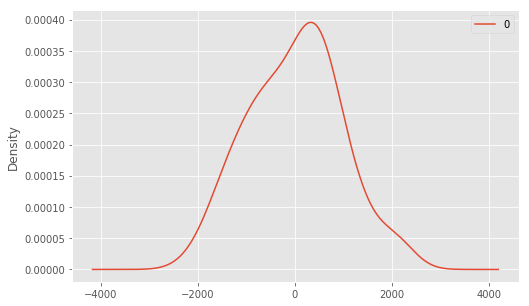

In [55]:
# check residual distribution
residuals = pd.DataFrame(high_model_fit2.resid)
residuals.plot(kind='kde')

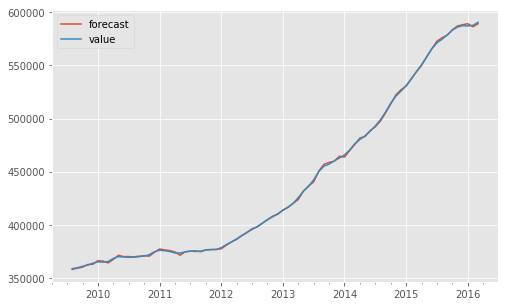

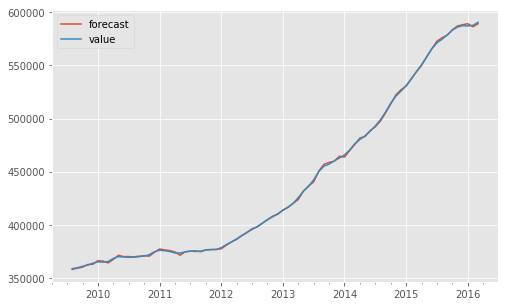

In [56]:
# compare at our forecast in comparison to the actual values for the second zip code
high_model_fit2.plot_predict()

In [57]:
# find the RMSE to test the model and check our predictions

In [61]:
y_hat2 = high_model_fit2.forecast(108)[0]
y_hat2 = y_hat2[86:]
len(y_hat2)

22

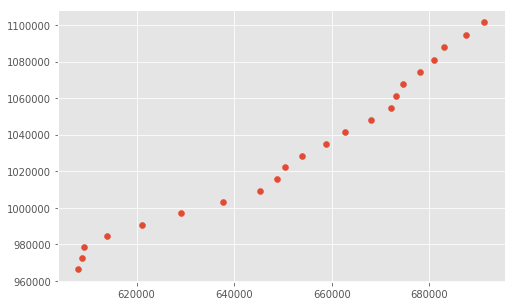

In [68]:
# check the root mean squared error
y_obs_test2 = test_df[test_df.RegionName == region_name2]

# get the last 22 observations
y_obs2 = y_obs_test2['value']
y_obs2 = y_obs2[3:]
RMSE = sqrt(mse(y_obs2, y_hat2)) # 1 1 0 lowest rmse
plt.scatter(y_obs2, y_hat2)

In [66]:
RMSE

380199.2249982779

# Step 6: Interpreting Results
Give a detailed interpretation of results including the relationship between the inputs and output of the model.

In [69]:
# predict the ROI at 2019-04-01 for model 2 (15206)
predict2019_2 = high_model_fit2.forecast(120)[0]

# 2019-04-01 predict value
yp_2019_2 = int(predict2019_2[-1])

# 2018-04-01 actual value
yobs_2018_2 = int(y_obs_test[y_obs_test.index == '2018-04-01']['value'])
# estimate the ROI 58318
model2_roi = (yp_2019_2 - yobs_2018_2)/yobs_2018_2*100
print(f"{round(model2_roi,2)}% return")

NameError: name 'y_obs_test' is not defined